# FSD301: Dynamically solving the TSP 

In [1]:
import networkx as nx
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from itertools import combinations

from reader_students import file_to_graph


## Define functions and class

In [2]:
def plot_graph(g):
    fig, ax = plt.subplots(figsize=(25, 6))
    ax.set_axis_off()
    ax.set_aspect(1)
    pos = nx.shell_layout(g)
    labels = nx.get_edge_attributes(g, 'weight')
    # print(labels)

    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, ax=ax)
    nx.draw_networkx(g, ax=ax, node_size=800, arrowsize=20, pos=pos)


In [3]:
class l_key:

    def __init__(self, s, destination):
        self.set = s
        self.destination = destination

    def __repr__(self):
        return f"({self.set},{self.destination})"

    def get_key(self):
        return "".join(str(e) for e in self.set) + str(self.destination)

In [4]:
def held_karp(graph):
    print(f"\nCompute TSP with Held-Karp...\n")
    # Initialize function variables
    nodes_list = np.array(list(graph.nodes())) # list of nodes by index
    # print(f"{nodes_list=}")
    initial_node = nodes_list[0]
    n = graph.number_of_nodes()
    L = dict()

    # Initialize L
    for i in range(1,n):
        cur_node = nodes_list[i]
        key = l_key({cur_node}, cur_node).get_key()
        cost = graph[initial_node][cur_node]['weight']
        L[key] = (cost, initial_node)
    # print(f"init L:{L}")

    # Loop on the graph
    for m in range(2,n):
        for subset in combinations(nodes_list[1:], m):
            # print(f"\nsubset:{subset}")
            for j in subset:
                subset_no_j = set(subset)
                subset_no_j.remove(j)
                subset_no_j = sorted(subset_no_j)
                # print(f"subset_no_j:{subset_no_j}")                
                paths = []
                for k in subset_no_j: 
                    cost_kj = graph[k][j]['weight']
                    # print(f"cost_kj:{cost_kj}")
                    cost_k = L[l_key(subset_no_j, k).get_key()][0]
                    # print(f"cost_k:{cost_k}")
                    paths.append((cost_k + cost_kj, k))
                min_path = min(paths)
                # print(f"paths:{paths}, min:{min_path}")
                L[l_key(subset, j).get_key()] = min_path
    
    # print(f"\nL before lat loop, L:{L}")

    # get back to initial node
    # print(f"\n\tGet back to initial node...")
    paths = []
    for j in range(1,n):
        # print(f"j:{nodes_list[j]}")
        cost_j1 = graph[nodes_list[j]][initial_node]['weight']
        # print(f"cost_j1:{cost_j1}")
        set_without_initial = sorted(set(nodes_list[1:]))
        cost_j = L[l_key(set_without_initial, nodes_list[j]).get_key()][0]
        # print(f"L[{{}},j]:{cost_j}")
        paths.append((cost_j + cost_j1, nodes_list[j]))
    min_path = min(paths)
    # print(f"paths:{paths}, min:{min_path}")

    return min_path


## Read graph data from .txt

In [5]:
# Exemple of parsing pof the .txt file with print
%run data/reader_students.py data/tsp5.txt

expected number of vertices : 5

reading point 0: (20833.3333, 17100.0)
reading point 1: (20900.0, 17066.6667)
reading point 2: (21300.0, 13016.6667)
reading point 3: (21600.0, 14150.0)
reading point 4: (21600.0, 14966.6667)

number of vertices: 5


In [6]:
?file_to_graph

Signature: file_to_graph(filename)
Docstring:
Read and parse a .txt file and return a nx.Graph generated from the data

Args:
    filename (str): The path to the .txt file containing the data on the cities

Returns:
    nx.Graph: The graph generated from the .txt file
File:      /mnt/storage/Documents/ISAE/3A/SDD/optim_graph/reader_students.py
Type:      function



Extracting graph from ./data/tsp5.txt ...
Found: 5 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7)]



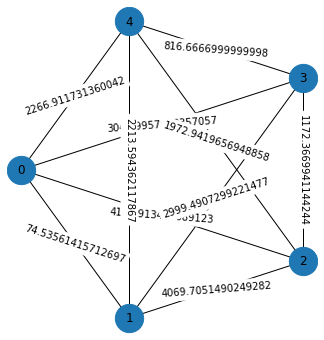

In [7]:
# f
graph5 = file_to_graph("./data/tsp5.txt")
plot_graph(graph5)

## Cours example


Compute TSP with Held-Karp...



(13, 'C')

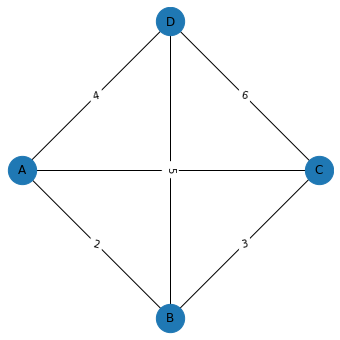

In [8]:
g = nx.Graph()
g.add_weighted_edges_from(
    zip(['A', 'A', 'A', 'B', 'B', 'C'],
        ['B', 'C', 'D', 'C', 'D', 'D'], 
        [2,1,4,3,5,6]),
)
plot_graph(g)
held_karp(g)

# Test on the tspXX.txt files examples

## With 5 cities

In [13]:
%%time
graph5 = file_to_graph("./data/tsp5.txt")
held_karp(graph5)


Extracting graph from ./data/tsp5.txt ...
Found: 5 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7)]


Compute TSP with Held-Karp...

CPU times: user 3.07 ms, sys: 0 ns, total: 3.07 ms
Wall time: 3.08 ms


(8387.077130278542, 1)

## With 10 cities

In [14]:
%%time
graph10 = file_to_graph("./data/tsp10.txt")
held_karp(graph10)



Extracting graph from ./data/tsp10.txt ...
Found: 10 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7)]


Compute TSP with Held-Karp...

CPU times: user 123 ms, sys: 0 ns, total: 123 ms
Wall time: 125 ms


(12349.980743996226, 1)

### With 15 cities

In [15]:
%%time
graph15 = file_to_graph("./data/tsp15.txt")
held_karp(graph15)


Extracting graph from ./data/tsp15.txt ...
Found: 15 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7), Point(23700.0,15933.3), Point(23883.3,14533.3), Point(24166.7,13250.0), Point(25149.2,12365.8), Point(26133.3,14500.0)]


Compute TSP with Held-Karp...

CPU times: user 9.4 s, sys: 0 ns, total: 9.4 s
Wall time: 9.41 s


(19269.93599779425, 4)

### With 20 cities

In [17]:
%%time
graph20 = file_to_graph("./data/tsp20.txt")
held_karp(graph20)


Extracting graph from ./data/tsp20.txt ...
Found: 20 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7), Point(23700.0,15933.3), Point(23883.3,14533.3), Point(24166.7,13250.0), Point(25149.2,12365.8), Point(26133.3,14500.0), Point(26150.0,10550.0), Point(26283.3,12766.7), Point(26433.3,13433.3), Point(26550.0,13850.0), Point(26733.3,11683.3)]


Compute TSP with Held-Karp...



KeyboardInterrupt: 

In [22]:
s = "[34,4]"
s.replaceA



'[34,4'